In [1]:
import os
import sys, inspect
import numpy as np
import math
import scipy.io
import scipy.stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from settings import MPIIGAZE_PATH
from data_processing.utils import mpii_face_gaze_path_wrapper, load_image_by_cv2, mpiigaze_path_wrapper
from data_processing.dataset_analysis import get_mpiigaze_data, get_processed_data_own_mpiigaze
from settings import RESULTS_PATH, FOR_THESIS_DIR

In [4]:
def get_mpiigaze_path(path):
    return os.path.join(MPIIGAZE_PATH, path)

## Try to open and show

In [5]:
path = get_mpiigaze_path("Data/Original/p01/day02/0020.jpg")

In [6]:
im = load_image_by_cv2(path)

In [7]:
print(im.shape)

(720, 1280, 3)


In [8]:
img = Image.fromarray(im, 'RGB')

In [9]:
# img.show()

## Get normalized

In [10]:
path = "Data/Normalized/p01/day02.mat"

In [11]:
path = os.path.join(MPIIGAZE_PATH, path)
matdata = scipy.io.loadmat(
    path, struct_as_record=False, squeeze_me=True)
data = matdata['data']

In [12]:
img = Image.fromarray(data.right.image[0], 'L')

In [13]:
# img.show()

## Get data about gaze and head pose

In [14]:
data.right.gaze[0]

array([-0.12259858,  0.09134563, -0.98824368])

In [15]:
data.left.gaze[0]

array([-0.11881702,  0.08861178, -0.98895423])

## 3G gaze target vs pixel coordinates

In [16]:
annotation = np.loadtxt(mpiigaze_path_wrapper("Data/Original/p00/day01/annotation.txt"))

In [17]:
theta_list = list()
phi_list = list()
x_list = list()
y_list = list()

for ann in annotation:
    gaze_target = ann[26:29]
    gaze_target = np.reshape(gaze_target, (-1, 1))
    tmp = gaze_target / np.linalg.norm(gaze_target)
    g_theta = math.degrees(np.arcsin((-1) * tmp[1].squeeze()))
    g_phi = math.degrees(np.arctan2((-1) * tmp[0].squeeze(), (-1) * tmp[2].squeeze()))
    
    coords = ann[24:26]
    
    print(f"gaze: ({g_theta}, {g_phi})\t coords: {coords}")
    theta_list.append(g_theta)
    phi_list.append(g_phi)
    x_list.append(coords[0])
    y_list.append(coords[1])
#     print(gaze_target.T)

gaze: (-37.524267512658454, 76.49838581635711)	 coords: [854. 270.]
gaze: (-64.5058465671731, 71.39197584225472)	 coords: [806. 630.]
gaze: (-46.861054061624785, 79.49951963940813)	 coords: [948. 467.]
gaze: (-41.56389170413497, -49.44440275642305)	 coords: [389. 166.]
gaze: (-79.8595437540148, -21.711763143280695)	 coords: [476. 758.]
gaze: (-49.479006576579195, 80.82006518857868)	 coords: [1005.  575.]
gaze: (-1.1230462445739833, 85.40353067200138)	 coords: [1140.   17.]
gaze: (-44.82641992671284, -71.3733567156306)	 coords: [ 94. 465.]
gaze: (-58.78084894406756, 56.242908231540305)	 coords: [664. 292.]
gaze: (-4.316793142356551, 85.14047586995213)	 coords: [1129.   51.]
gaze: (-14.462523103443635, 72.04682189793569)	 coords: [768.  76.]
gaze: (-33.919905099045586, 82.15940222794117)	 coords: [1024.  346.]
gaze: (-72.56387098545572, 30.881075878887454)	 coords: [585. 398.]
gaze: (-44.551500955370045, 85.27236863741888)	 coords: [1276.  743.]
gaze: (-47.014420418227395, 84.30861210375

In [18]:
pairs = [(theta_list, x_list),
        (theta_list, y_list),
        (phi_list, x_list),
        (phi_list, y_list)]

for pair in pairs:
    p = scipy.stats.pearsonr(pair[0], pair[1])[0]
    s = scipy.stats.spearmanr(pair[0], pair[1])[0]
    print(f"{p}\t{s}")
    print()

0.222743674607207	0.22545732581704664

-0.7916721143125867	-0.7644232780874304

0.9494968237321637	0.9976773728024108

-0.01585725339257079	-0.03546065559569292



# Data distribution

In [19]:
figures_dir = os.path.join(RESULTS_PATH, "for_thesis")
os.makedirs(figures_dir, exist_ok=True)

In [20]:
image_counter, x_coords, y_coords, df_untrusted = get_mpiigaze_data()

In [21]:
x = list(image_counter.keys())
y = list(image_counter.values())
y_percent = np.round(np.asarray(y) / np.sum(y) * 100.0, 2)

In [22]:
fig = plt.figure(figsize=(20, 15))
ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Id osoby", fontsize=24)
ax.set_ylabel("Liczba zdjęć", fontsize=24)
plt.savefig(os.path.join(figures_dir, "mpiigaze_person_distribution.png"))

In [23]:
df = pd.DataFrame({"Id osoby": x, "Liczba zdjęć": y, "Część zbioru (%)": y_percent})
df

,Id osoby,Liczba zdjęć,Część zbioru (%)
0,0,29961,14.11
1,1,24143,11.37
2,2,28007,13.19
3,3,35075,16.52
4,4,16831,7.93
5,5,16577,7.81
6,6,18448,8.69
7,7,14145,6.66
8,8,10701,5.04
9,9,7995,3.77


In [24]:
latex = df.to_latex(index=False).replace(".", ",")
with open(os.path.join(figures_dir, "mpiigaze_person_dist.txt"), 'w') as file:
    file.write(latex)

In [25]:
fig = plt.figure(figsize=(20, 15))
ax = sns.distplot(x_coords, kde=False)
ax.set_xlabel("Znormalizowana wartość współrzędnej x", fontsize=24)
ax.set_ylabel("Liczba zdjęć", fontsize=24)
plt.savefig(os.path.join(figures_dir, "mpiigaze_x_distribution.png"))

In [26]:
fig = plt.figure(figsize=(20, 15))
ax = sns.distplot(y_coords, kde=False)
ax.set_xlabel("Znormalizowana wartość współrzędnej y", fontsize=24)
ax.set_ylabel("Liczba zdjęć", fontsize=24)
plt.savefig(os.path.join(figures_dir, "mpiigaze_y_distribution.png"))

In [27]:
df_untrusted = df_untrusted.groupby(["person_id", "day"]).count().reset_index()

In [28]:
df_untrusted = df_untrusted.rename({"person_id": "Id osoby", "day": "Dzień", "counter": "Liczba zdjęć"}, axis=1)
df_untrusted

,Id osoby,Dzień,Liczba zdjęć
0,02,21,12
1,07,02,36
2,07,04,35
3,07,06,135
4,07,07,12
5,07,11,55
6,07,12,163
7,07,13,32
8,07,14,46
9,07,15,104


In [29]:
latex = df_untrusted.to_latex(index=False).replace(".", ",")
with open(os.path.join(figures_dir, "mpiigaze_anomalies.txt"), 'w') as file:
    file.write(latex)

In [30]:
np.sum(y) + np.sum(df_untrusted["Liczba zdjęć"].values)

213658

# Own + Mpiigaze

In [36]:
p23_len = 1549

In [34]:
right_images, left_images, poses, gazes, subject_ids = get_processed_data_own_mpiigaze()

In [38]:
mpiigaze_poses = poses[:len(poses) - p23_len]
own_poses = poses[len(mpiigaze_poses):]

In [40]:
print(len(mpiigaze_poses) + len(own_poses))
print(len(poses))

38488
38488


In [54]:
def plot_dists(poses):
    fig = plt.figure(figsize=(30, 20))
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        x = poses[:, i]
        ax = sns.distplot(x)
    return fig

## MPIIGaze

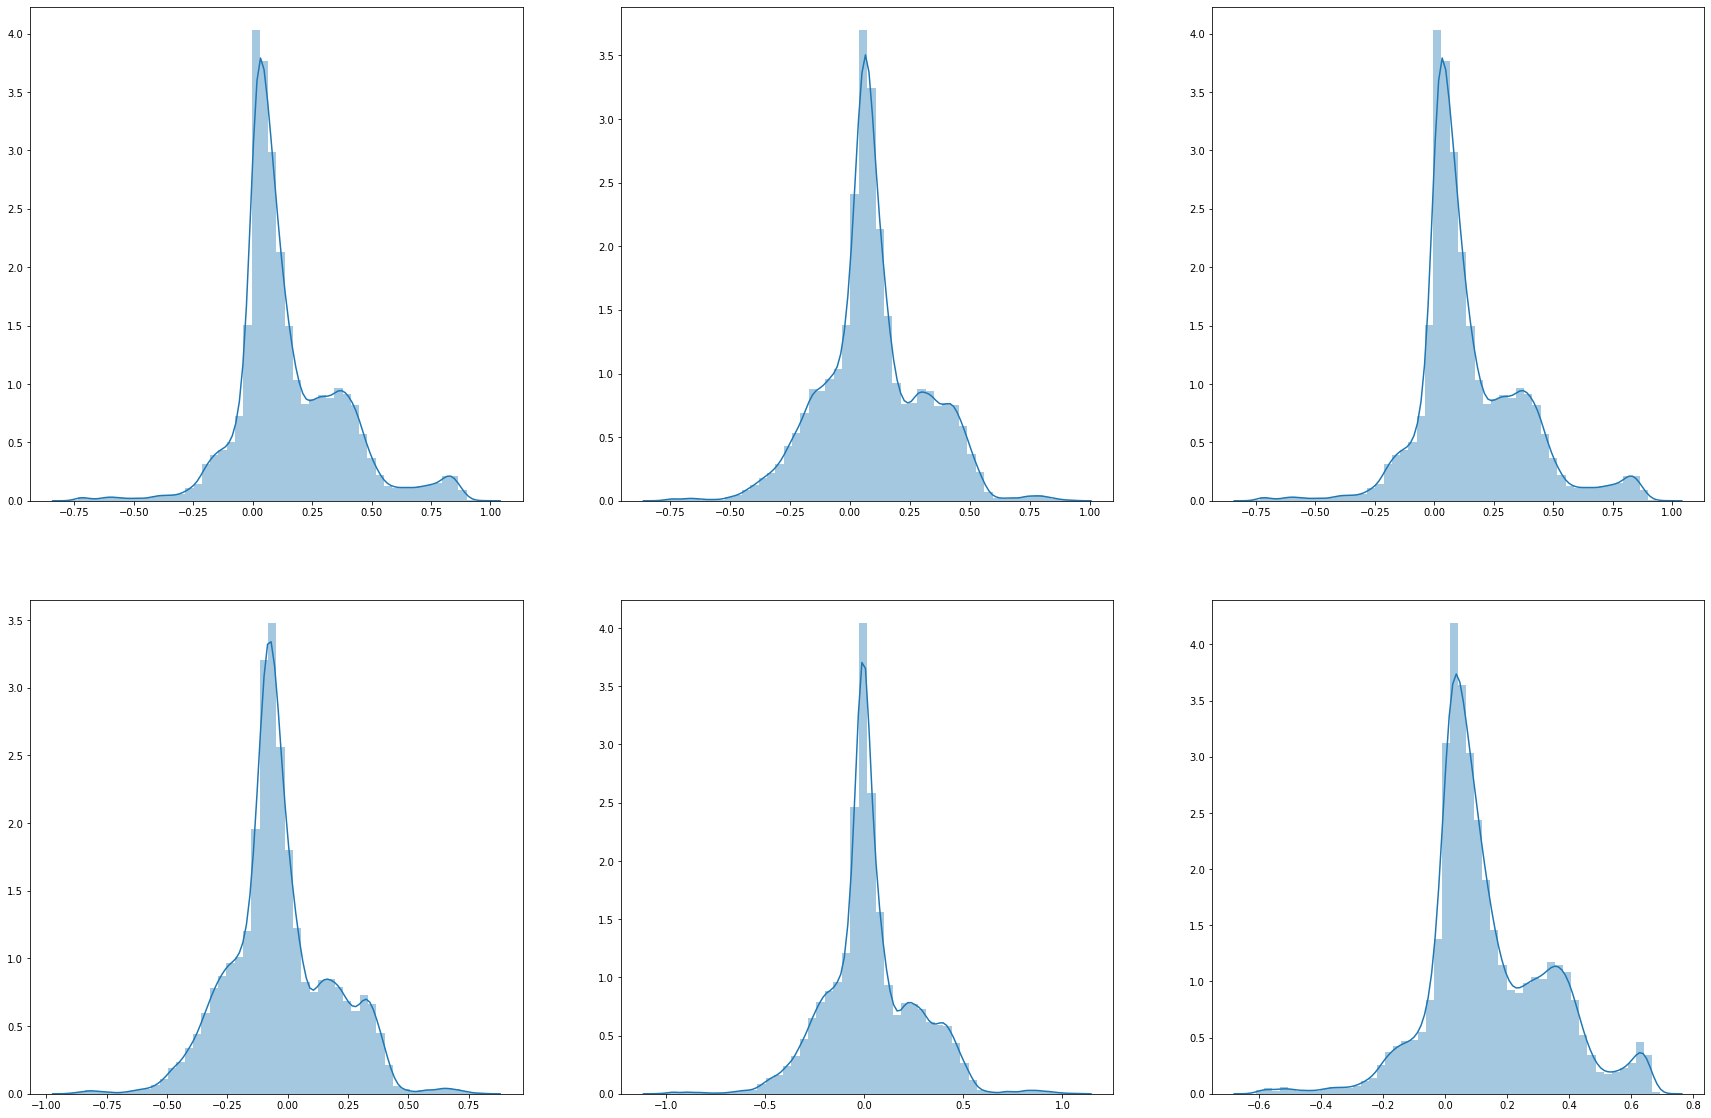

In [55]:
plot_dists(mpiigaze_poses[:, :6])

## Own dataset

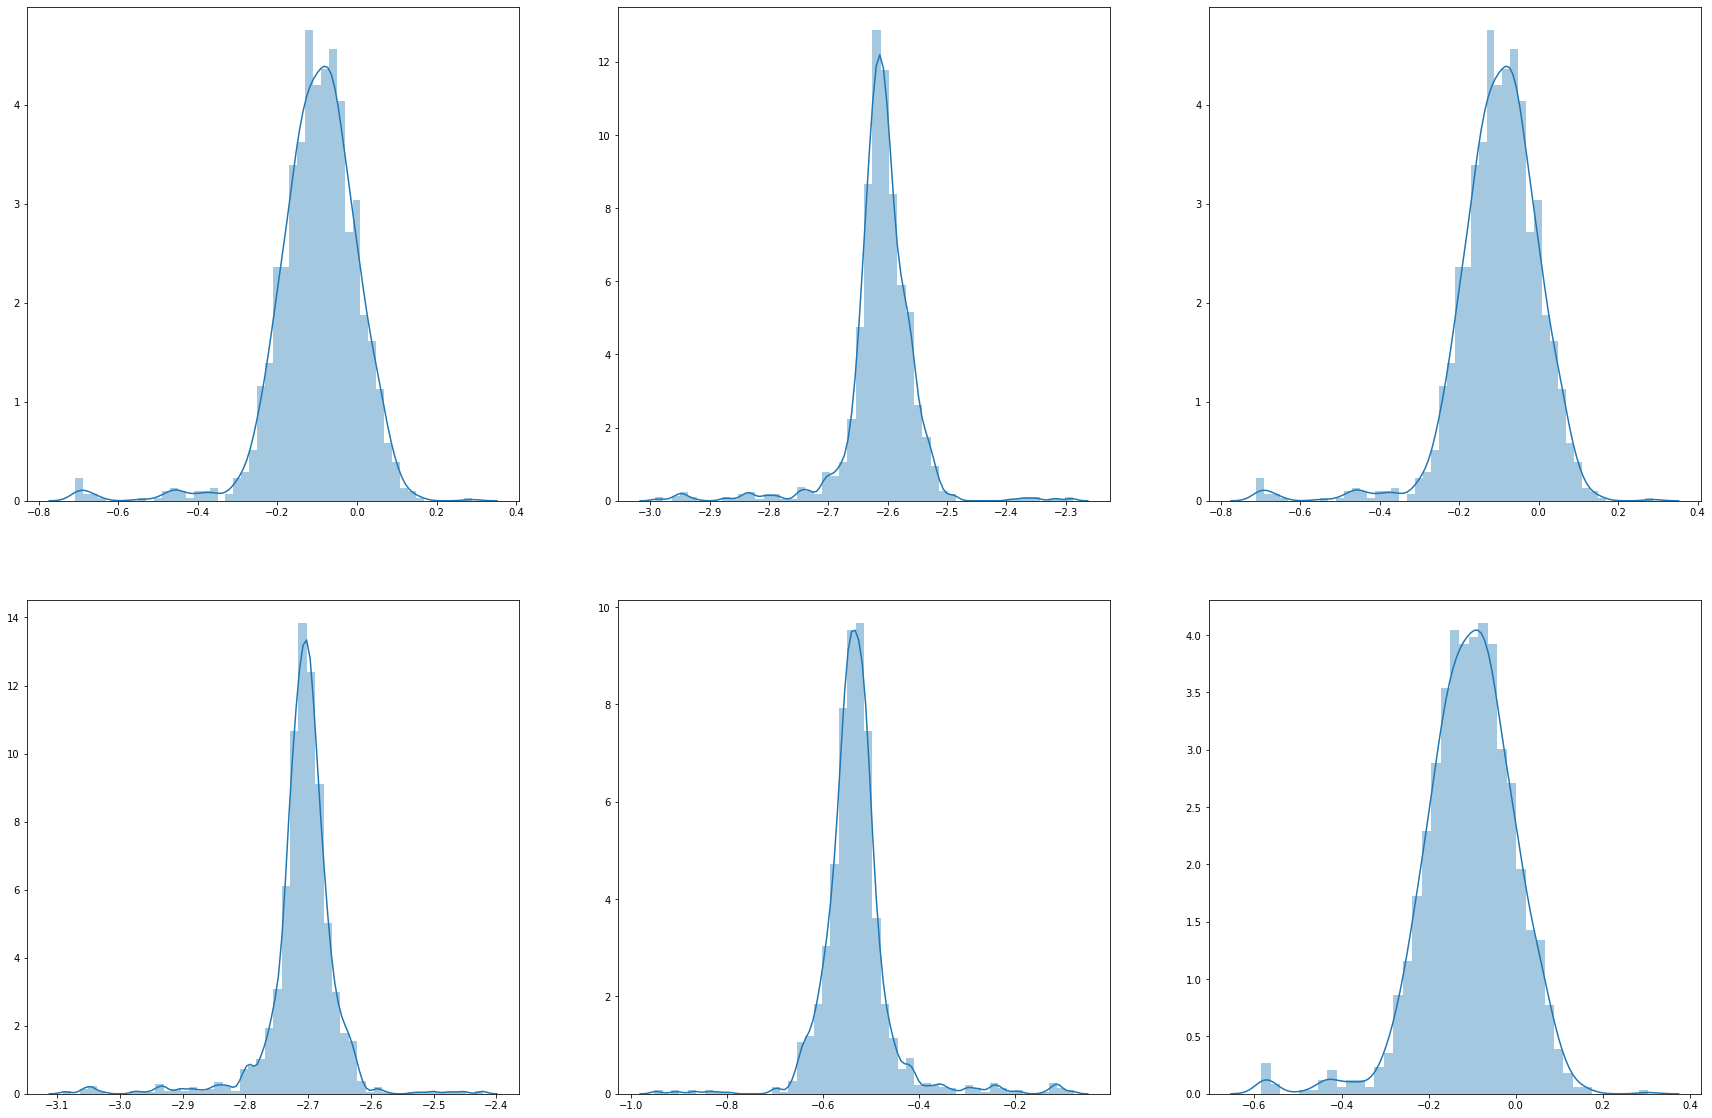

In [56]:
plot_dists(own_poses[:, :6])